In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight #样本不平衡 加权
from scipy.stats import randint, uniform

data = pd.read_csv('/root/autodl-tmp/统计建模/data with AE(latent dim=6).csv')
X = data.drop(columns=['Diagnosis']).values
y = data['Diagnosis'].values
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#样本不平衡 加权
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))  # 转换为字典格式[5](@ref)
class_weights_dict
#sum/2/sum_0   sum/2/sum_1

{0: np.float64(0.6515189805561299), 1: np.float64(2.1499583027975033)}

In [11]:
param_grid = {
    'n_estimators':randint(100, 200),
    'max_depth': randint(1,10),
    'min_samples_split': randint(1,10),
    'min_samples_leaf': randint(1,10),
    'max_features': ['sqrt', None],
}

# 初始化带类别权重的基准模型
base_model = RandomForestClassifier(
    random_state=42,
    class_weight=class_weights_dict,
    n_jobs=-1# 启用并行计算
)

random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=50,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        random_state=42
)

# 执行搜索
random_search.fit(X_train, y_train)

/root/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/root/miniconda3/lib/python3.1

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: np.float64(0.6515189805561299),
                                                                  1: np.float64(2.1499583027975033)},
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f98b459fe60>,
                                        'max_features': ['sqrt', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f98b45954c0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f98b4595430>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f98cc8b6fc0>},
                   random_state=42, scoring='accuracy')

<span style="font-size: 20px;">最优超参数

In [12]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 189}


In [3]:
model = RandomForestClassifier(
    n_estimators=189,
    max_depth=9,
    max_features=None,
    min_samples_leaf=2,
    min_samples_split=9,
    random_state=42,
    class_weight=class_weights_dict,
    oob_score=True# 启用并行计算
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred,digits=4))

Confusion Matrix:
[[30659  1956]
 [ 5484  4440]]
Accuracy: 0.8251
              precision    recall  f1-score   support

           0     0.8483    0.9400    0.8918     32615
           1     0.6942    0.4474    0.5441      9924

    accuracy                         0.8251     42539
   macro avg     0.7712    0.6937    0.7180     42539
weighted avg     0.8123    0.8251    0.8107     42539



In [6]:
#训练集精度
accuracy_score( y_train, model.predict(X_train) )

0.82803023179275

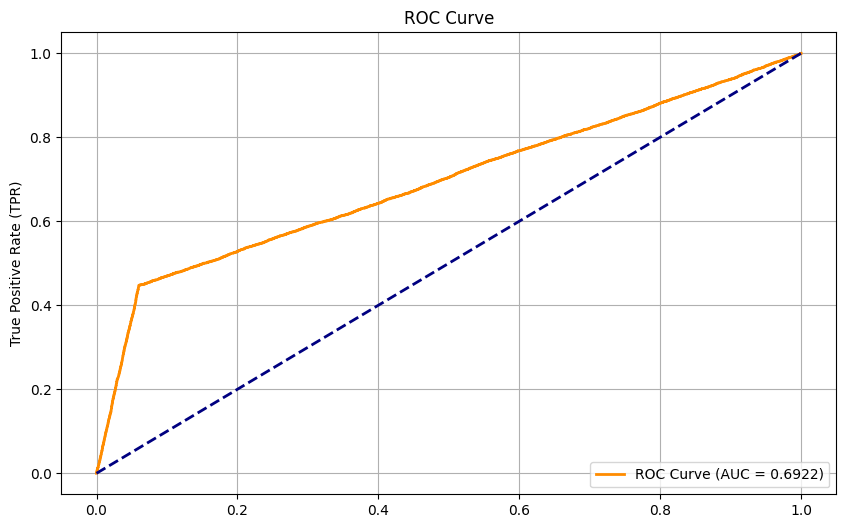

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score=model.predict_proba(X_test)[:,1]
# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
roc_auc = roc_auc_score(y_test, y_score)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [9]:
#保存预测值，为后续画图
# 将y_score转为DataFrame并自定义列名
combined_df = pd.DataFrame({
    'Random Forest': y_score
})
combined_df.to_csv('Random Forest.csv', index=False)